In [1]:
# import data manipulation libraries
import pandas as pd
import numpy as np
import datetime
import warnings
import pickle

# Facebook Prophet forecasting library
from fbprophet import Prophet

# Libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Sorting, find largest
import heapq

In [2]:
#Give colab permissions to access Google Drive

!pip install PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#https://drive.google.com/open?id=1vWXFYBkDola8nx7U8EmDsfyy_rk9dmqD

download1 = drive.CreateFile({'id': '1vWXFYBkDola8nx7U8EmDsfyy_rk9dmqD'})
download1.GetContentFile('DOWNLOAD.tar')

In [5]:
download1.GetContentFile('SDPD_incident.csv')


In [6]:
raw = pd.read_csv('SDPD_incident.csv', encoding = "ISO-8859-1")
raw.head()

,id,date,year,month,day,week,dow,time,hour,is_night,...,comm_pop,council,council_pop,asr_zone,lampdist,lat,lon,desc,gctype,gcquality
0,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,33.137756,-117.266499,PETTY THEFT,cns/segment,65
1,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.630291,-117.004355,FRAUD,cns/segment,65
2,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,33.193405,-117.316456,FRAUD,cns/segment,22
3,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.655955,-116.958372,FRAUD,cns/segment,65
4,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.626110,-117.079400,FRAUD,cns/segment,65


In [7]:
raw.shape

(797978, 26)

In [8]:
raw.type.unique()

array(['THEFT/LARCENY', 'FRAUD', 'ASSAULT', 'SEX CRIMES', 'VANDALISM',
       'VEHICLE BREAK-IN/THEFT', 'BURGLARY', 'MOTOR VEHICLE THEFT',
       'ROBBERY', 'DRUGS/ALCOHOL VIOLATIONS', 'DUI', 'WEAPONS', 'ARSON',
       'HOMICIDE'], dtype=object)

In [9]:
raw.shape

(797978, 26)

In [10]:
raw.groupby('type')['day'].count()

type
ARSON                         1651
ASSAULT                      69055
BURGLARY                     71377
DRUGS/ALCOHOL VIOLATIONS    185135
DUI                          47098
FRAUD                        43955
HOMICIDE                       368
MOTOR VEHICLE THEFT          70066
ROBBERY                      17002
SEX CRIMES                   17439
THEFT/LARCENY               108939
VANDALISM                    61439
VEHICLE BREAK-IN/THEFT       95616
WEAPONS                       8838
Name: day, dtype: int64

In [11]:
pivot = raw.groupby('desc')['day'].count().reset_index()

In [12]:
pivot.sort_values(by = ['day'], ascending = False).head(15)

,desc,day
864,VEHICLE BREAK-IN/THEFT,95616
763,TAKE VEHICLE W/O OWNER'S CONSENT/VEHICLE THEFT,66010
242,DISORDERLY CONDUCT: ALCOHOL,50842
682,RESIDENTIAL BURGLARY,45463
303,FRAUD,43955
262,DUI ALCOHOL AND/OR DRUGS,40688
514,PETTY THEFT,34305
199,COMMERCIAL BURGLARY,25914
490,OPEN CONTAINER IN PUBLIC PARK,22543
843,VANDALISM ($400 OR MORE),21989


In [13]:
sd_crime = raw[['date', 'year']]
sd_crime = sd_crime.groupby(['date', 'year']).date.agg('count').to_frame('incidents').reset_index()
sd_crime = sd_crime.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
sd_crime = sd_crime[['date', 'incidents']]

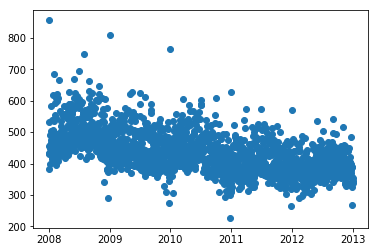

In [14]:
from matplotlib import pyplot
import matplotlib.dates as mpdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

dates = pd.to_datetime(sd_crime['date'], infer_datetime_format=True)
dates = mpdates.date2num(dates) 
incidents = sd_crime.incidents
pyplot.plot_date(dates, incidents)

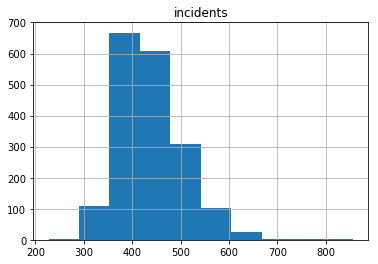

In [15]:
sd_crime.hist()
pyplot.show()

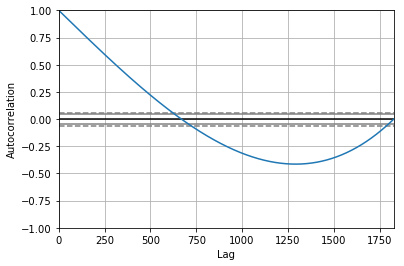

In [16]:
from pandas.plotting import autocorrelation_plot
sd_crime_ac = pd.DataFrame(dates, incidents)
autocorrelation_plot(sd_crime_ac)

In [17]:
weather = pd.read_csv('sd_weather.csv', dialect='excel', encoding = "ISO-8859-1",skiprows=range(1,2923),
                      nrows=1827, header = 0)
weather = weather.rename(columns={'Date': 'date'})
Temp = weather[['date', 'TMax']]
Rain = weather[['date', 'Precip']]
All = weather[['date', 'TMax', 'Precip']]

In [18]:
weather.shape

(1827, 5)

In [19]:
crime_temp = pd.merge(sd_crime, Temp, on='date')
crime_rain = pd.merge(sd_crime, Rain, on='date')
crime_weather = pd.merge(sd_crime, All, on='date')

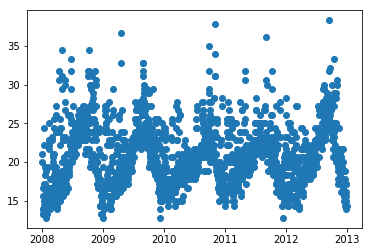

In [20]:
tdates = pd.to_datetime(crime_temp['date'], infer_datetime_format=True)
tdates = mpdates.date2num(tdates) 
tmax = crime_temp.TMax
pyplot.plot_date(tdates, tmax)

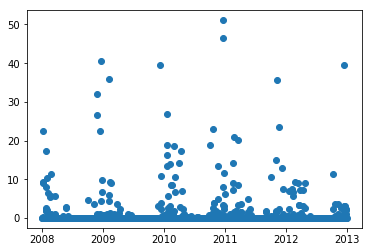

In [21]:
tdates = pd.to_datetime(crime_rain['date'], infer_datetime_format=True)
tdates = mpdates.date2num(tdates) 
rain = crime_rain.Precip
pyplot.plot_date(tdates, rain)

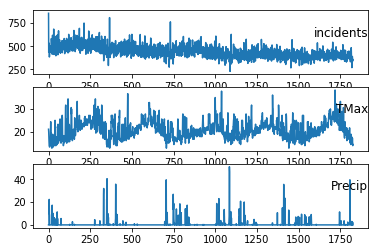

In [22]:
import matplotlib.pyplot as pyplot
values = crime_weather.values
# specify columns to plot
groups = [1,2,3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(crime_weather.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

           incidents      TMax
incidents   1.000000  0.092484
TMax        0.092484  1.000000


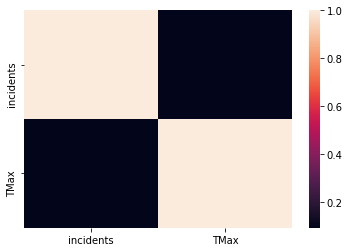

In [23]:
#import matplotlib.pyplot as plt
import seaborn as sns
corr = crime_temp.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
             yticklabels=corr.columns.values)

           incidents    Precip
incidents   1.000000 -0.126995
Precip     -0.126995  1.000000


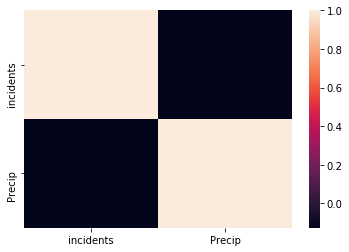

In [24]:
corr = crime_rain.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
             yticklabels=corr.columns.values)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


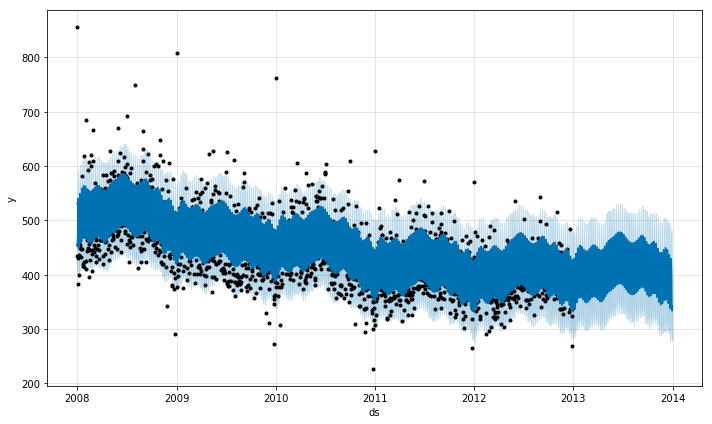

In [25]:
# renaming columns for prophet compatability
sd_crime = sd_crime.rename(columns={'date': 'ds', 'incidents': 'y'},index=str)

sd_crime.head()


# create a model using Prophet
m = Prophet()
m.fit(sd_crime)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)

fig1 = m.plot(forecast)



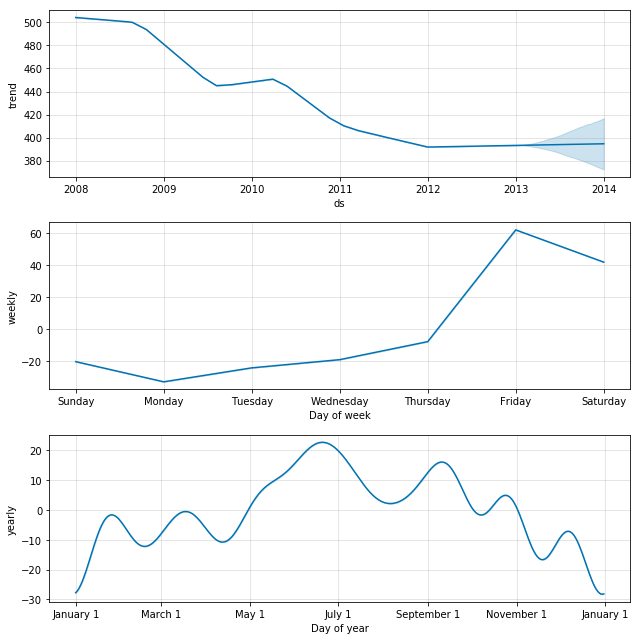

In [26]:
fig2 = m.plot_components(forecast)

In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2187,2013-12-27,429.357975,370.553152,484.205132
2188,2013-12-28,408.704984,350.137133,467.077986
2189,2013-12-29,346.107351,286.868208,402.492078
2190,2013-12-30,333.395723,278.261661,389.447558
2191,2013-12-31,342.232545,283.322187,399.682071


In [28]:
#crime_temp
crime_rain.head()

,date,incidents,Precip
0,2008-01-01,856,0.0
1,2008-01-02,434,0.0
2,2008-01-03,457,0.0
3,2008-01-04,532,0.3
4,2008-01-05,431,22.4


In [29]:
rain_holidays= crime_rain.loc[(crime_rain['Precip'] >= 10)] 

rain_holidays.head()

,date,incidents,Precip
4,2008-01-05,431,22.4
22,2008-01-23,420,17.3
26,2008-01-27,423,10.2
52,2008-02-22,600,11.4
330,2008-11-26,495,26.7


In [30]:
rain_list = rain_holidays['date'].tolist()
rain_list

['2008-01-05',
 '2008-01-23',
 '2008-01-27',
 '2008-02-22',
 '2008-11-26',
 '2008-11-27',
 '2008-12-15',
 '2008-12-17',
 '2009-02-07',
 '2009-12-07',
 '2009-12-13',
 '2010-01-18',
 '2010-01-19',
 '2010-01-20',
 '2010-01-21',
 '2010-02-06',
 '2010-02-27',
 '2010-03-07',
 '2010-04-01',
 '2010-04-12',
 '2010-10-06',
 '2010-10-19',
 '2010-11-20',
 '2010-12-21',
 '2010-12-22',
 '2010-12-29',
 '2011-02-18',
 '2011-02-26',
 '2011-03-20',
 '2011-10-05',
 '2011-11-04',
 '2011-11-12',
 '2011-11-20',
 '2011-12-12',
 '2012-10-12',
 '2012-12-13']

In [31]:
holidays = pd.DataFrame({
  'holiday': 'rain',
  'ds': pd.to_datetime(rain_list),
  'lower_window': 0,
  'upper_window': 1,
})
holidays.head()

,holiday,ds,lower_window,upper_window
0,rain,2008-01-05,0,1
1,rain,2008-01-23,0,1
2,rain,2008-01-27,0,1
3,rain,2008-02-22,0,1
4,rain,2008-11-26,0,1


In [32]:
#if you run into an error here, try to run the following install:
#!pip install pandas --upgrade

In [33]:
# create new prophet model with rain as holidays

m2 = Prophet(holidays=holidays)
forecast2 = m2.fit(sd_crime).predict(future)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-01,504.309204,397.465658,502.634807,504.309204,504.309204,-52.230086,-52.230086,-52.230086,-24.182061,-24.182061,-24.182061,-28.048025,-28.048025,-28.048025,0.0,0.0,0.0,452.079118
1,2008-01-02,504.292329,406.155843,505.917845,504.292329,504.292329,-46.691450,-46.691450,-46.691450,-19.040392,-19.040392,-19.040392,-27.651058,-27.651058,-27.651058,0.0,0.0,0.0,457.600879
2,2008-01-03,504.275454,415.642819,520.766668,504.275454,504.275454,-34.828720,-34.828720,-34.828720,-7.764842,-7.764842,-7.764842,-27.063879,-27.063879,-27.063879,0.0,0.0,0.0,469.446734
3,2008-01-04,504.258579,487.561774,591.879633,504.258579,504.258579,35.889077,35.889077,35.889077,62.184964,62.184964,62.184964,-26.295887,-26.295887,-26.295887,0.0,0.0,0.0,540.147656
4,2008-01-05,504.241705,469.218452,573.404505,504.241705,504.241705,16.652298,16.652298,16.652298,42.011855,42.011855,42.011855,-25.359557,-25.359557,-25.359557,0.0,0.0,0.0,520.894003


In [35]:
# filter forecast results to only days where 'holiday' makes impact
forecast2[(forecast2['holidays']).abs()>0][
    ['ds','holidays']][-10:]


,ds,holidays
1411,2011-11-12,-34.469084
1412,2011-11-13,-14.834497
1419,2011-11-20,-34.469084
1420,2011-11-21,-14.834497
1441,2011-12-12,-34.469084
1442,2011-12-13,-14.834497
1746,2012-10-12,-34.469084
1747,2012-10-13,-14.834497
1808,2012-12-13,-34.469084
1809,2012-12-14,-14.834497


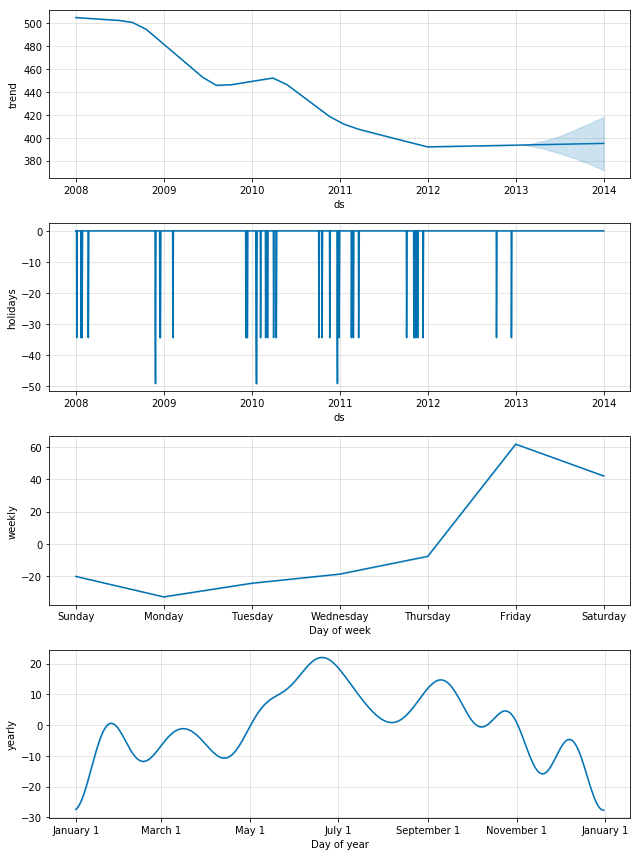

In [36]:
fig2 = m2.plot_components(forecast2)


In [37]:
temp_holidays= crime_temp.loc[(crime_temp['TMax'] >= 25)] 

temp_holidays.head()


,date,incidents,TMax
39,2008-02-09,593,25.0
69,2008-03-10,435,25.6
82,2008-03-23,429,27.2
83,2008-03-24,484,26.1
102,2008-04-12,479,30.6


In [38]:
temp_list = temp_holidays['date'].tolist()
#temp_list


In [39]:
holidays = pd.DataFrame({
  'holiday': 'hot_day',
  'ds': pd.to_datetime(temp_list),
  'lower_window': 0,
  'upper_window': 1,
})
holidays.head()

,holiday,ds,lower_window,upper_window
0,hot_day,2008-02-09,0,1
1,hot_day,2008-03-10,0,1
2,hot_day,2008-03-23,0,1
3,hot_day,2008-03-24,0,1
4,hot_day,2008-04-12,0,1


In [40]:
# create new prophet model with rain as holidays

m3 = Prophet(holidays=holidays)
forecast3 = m3.fit(sd_crime).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
# filter forecast results to only days where 'holiday' makes impact
forecast3[(forecast3['holidays']).abs()>0][
    ['ds','holidays']][-10:]

,ds,holidays
1750,2012-10-16,8.740902
1751,2012-10-17,8.740902
1752,2012-10-18,1.221010
1760,2012-10-26,7.519892
1761,2012-10-27,8.740902
1762,2012-10-28,8.740902
1763,2012-10-29,1.221010
1769,2012-11-04,7.519892
1770,2012-11-05,8.740902
1771,2012-11-06,1.221010


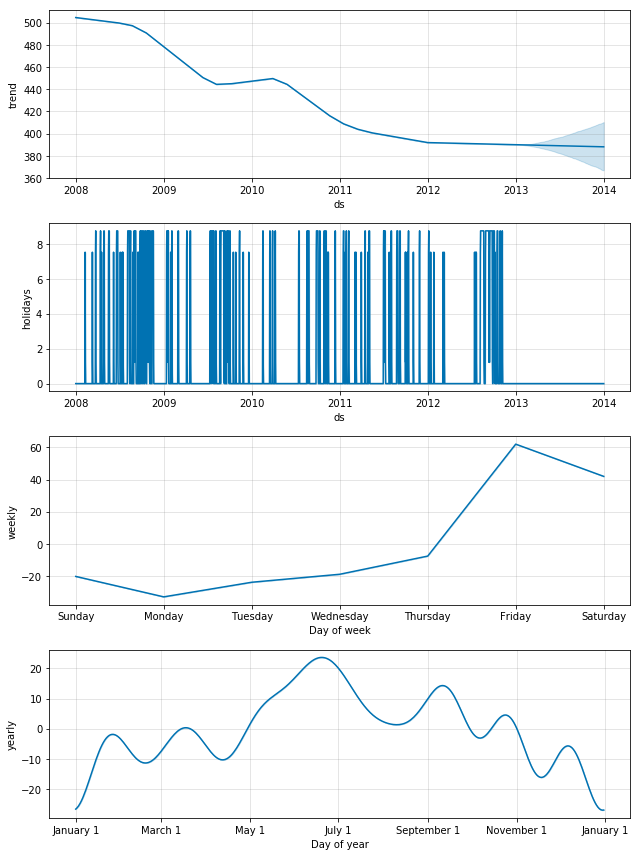

In [42]:
fig3 = m3.plot_components(forecast3)

In [43]:
rain = pd.DataFrame({
  'holiday': 'rain',
  'ds': pd.to_datetime(rain_list),
  'lower_window': 0,
  'upper_window': 1,
})

temp = pd.DataFrame({
  'holiday': 'hot_day',
  'ds': pd.to_datetime(temp_list),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((rain, temp))

In [44]:
m4 = Prophet(holidays=holidays)
forecast4 = m4.fit(sd_crime).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
# filter forecast results to only days where 'holiday' makes impact
forecast4[(forecast4['holidays']).abs()>0][
    ['ds','holidays']][-10:]

,ds,holidays
1752,2012-10-18,0.562770
1760,2012-10-26,6.902159
1761,2012-10-27,7.464929
1762,2012-10-28,7.464929
1763,2012-10-29,0.562770
1769,2012-11-04,6.902159
1770,2012-11-05,7.464929
1771,2012-11-06,0.562770
1808,2012-12-13,-33.753364
1809,2012-12-14,-14.258708


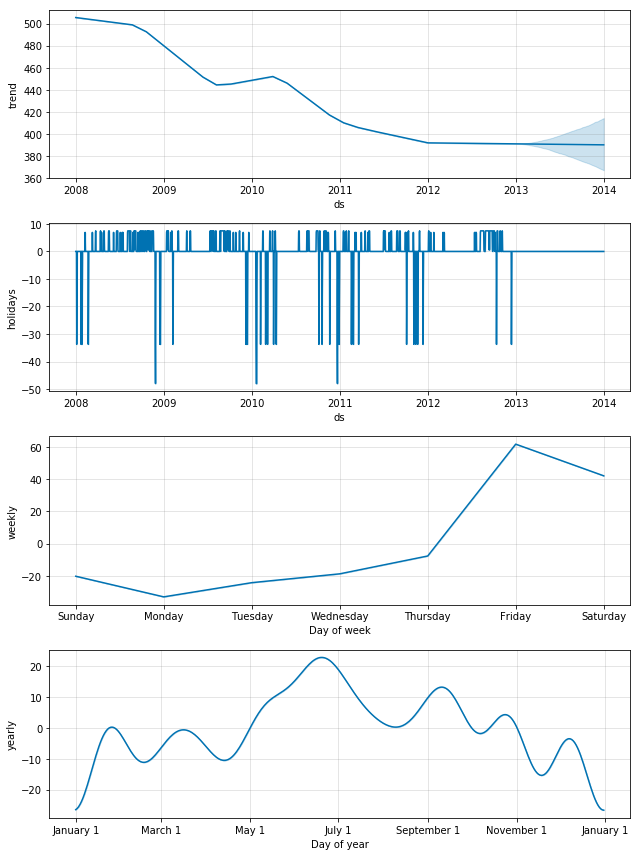

In [46]:
fig4 = m4.plot_components(forecast4)

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt
crime_count = sd_crime['y']
y_pred = forecast.loc[:, 'yhat']
y_pred = y_pred[:1827,]

sqrt(mean_squared_error(crime_count, y_pred))

40.35303407755114

In [48]:
crime_count.mean()

436.76956759715381

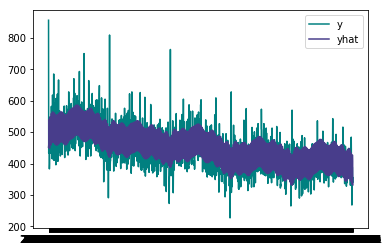

In [49]:
import matplotlib.dates as mpdates
error = pd.concat([sd_crime.reset_index(), y_pred], axis=1)
pyplot.plot(error.ds, error.y, color='teal')
pyplot.plot(error.ds, error.yhat, color='darkslateblue')
pyplot.legend(['y', 'yhat'])
pyplot.show()

In [50]:
crime_temp.TMax.max()

38.299999999999997

In [51]:
crime_temp.TMax.min()

12.800000000000001

In [52]:
hottest = crime_temp.loc[crime_temp.TMax == 38.3, 'date']

In [53]:
hottest

1719    2012-09-15
Name: date, dtype: object

In [54]:
coldest = crime_temp.loc[crime_temp.TMax == 12.8, 'date']

In [55]:
coldest

20      2008-01-21
367     2009-01-02
707     2009-12-08
1442    2011-12-13
Name: date, dtype: object

In [56]:
hottestDF = raw.loc[raw['date'] == '2012-09-15']


In [57]:
list(hottestDF)

['id',
 'date',
 'year',
 'month',
 'day',
 'week',
 'dow',
 'time',
 'hour',
 'is_night',
 'type',
 'address',
 'city',
 'segment_id',
 'nbrhood',
 'community',
 'comm_pop',
 'council',
 'council_pop',
 'asr_zone',
 'lampdist',
 'lat',
 'lon',
 'desc',
 'gctype',
 'gcquality']

In [58]:
coldestDF = raw.loc[raw['date'] == '2011-12-13'] #pick one because multiple days are cold


In [59]:
#source: https://plot.ly/python/county-choropleth/
import plotly.plotly as py
import plotly.figure_factory as ff
import numpy as np
import plotly 
plotly.tools.set_credentials_file(username='bjniskal', api_key='hUb4Fot1yifA9T5LXGgp') #have to sign up for account

ModuleNotFoundError: No module named 'plotly'

In [ ]:
import plotly.graph_objs as go

In [ ]:
#Source: https://plot.ly/python/scattermapbox/

mapbox_access_token = 'pk.eyJ1IjoiYmpuaXNrYWwiLCJhIjoiY2p0bmN5dm9sMHFtMzQzcXU1cnNjOHU2cSJ9.EOwJto794sHSWBcpLlAbIA'

data = [
    go.Scattermapbox(
        lat = hottestDF.lat,
        lon =hottestDF.lon,
        mode = 'markers',
        marker = go.scattermapbox.Marker(
            size = 5
        ),
        text = hottestDF.desc,
        
    )
]

In [ ]:
layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat = 32.71,
            lon = -117.16
        ),
        pitch=0,
        zoom=10
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='SD Crime on Max Temp')

In [ ]:
mapbox_access_token = 'pk.eyJ1IjoiYmpuaXNrYWwiLCJhIjoiY2p0bmN5dm9sMHFtMzQzcXU1cnNjOHU2cSJ9.EOwJto794sHSWBcpLlAbIA'

data = [
    go.Scattermapbox(
        lat = coldestDF.lat,
        lon =coldestDF.lon,
        mode = 'markers',
        marker = go.scattermapbox.Marker(
            size = 5
        ),
        text = coldestDF.desc,
        
    )
]

In [ ]:
layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat = 32.71,
            lon = -117.16
        ),
        pitch=0,
        zoom=10
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='SD Crime on Min Temp')

In [ ]:
raw.date = pd.to_datetime(raw.date)

In [ ]:
weather.date = pd.to_datetime(weather.date)

In [ ]:
weather.head()


In [ ]:
crimeByDay = raw.groupby('date').size()

In [ ]:
crimeByDay = {'date' : crimeByDay.index, 'crimeCount' : list(crimeByDay)}

In [ ]:
crimeByDay = pd.DataFrame(crimeByDay)

In [ ]:
crimeWeather = crimeByDay.merge(weather, left_on = 'date', right_on = 'date')

In [ ]:
#Sourced code from: https://matplotlib.org/gallery/api/two_scales.html
t = crimeWeather.date
data1 = crimeWeather.crimeCount
data2 = crimeWeather.TMax

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Crime Count', color = color)
ax1.plot(t, data1, color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:gray'
ax2.set_ylabel('Max Temperture', color = color)  
ax2.plot(t, data2, color=color, alpha = 0.5)
ax2.tick_params(axis ='y', labelcolor = color)

fig.tight_layout()  # with out this the right y-label is cut off
plt.title('Crime Count VS. Max Temp by day')
plt.show()